In [18]:
import os, sys, argparse
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torchvision
import wandb

import datasets
# from utils import select_device, natural_keys, gazeto3d, angular, getArch
from utils import select_device, natural_keys, gazeto3d, angular, getArch
from model import L2CS

In [28]:
print(argparse.__file__)

/usr/lib/python3.8/argparse.py


In [20]:
# check if we have the correct number of checkpoint files 
ppath ='/project/results/output/snapshots/' 
for fold in range(15):
    foldstr = f"fold{fold:0>2}"
    cpath =os.path.join(ppath, foldstr)
    files = os.listdir(cpath)
    print(len(files), end=" ")

61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 

In [3]:
def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(
        description='Gaze estimation using L2CSNet .')
     # Gaze360
    parser.add_argument(
        '--gaze360image_dir', dest='gaze360image_dir', help='Directory path for gaze images.',
        default='datasets/Gaze360/Image', type=str)
    parser.add_argument(
        '--gaze360label_dir', dest='gaze360label_dir', help='Directory path for gaze labels.',
        default='datasets/Gaze360/Label/test.label', type=str)
    # mpiigaze
    parser.add_argument(
        '--gazeMpiimage_dir', dest='gazeMpiimage_dir', help='Directory path for gaze images.',
        default='datasets/MPIIFaceGaze/Image', type=str)
    parser.add_argument(
        '--gazeMpiilabel_dir', dest='gazeMpiilabel_dir', help='Directory path for gaze labels.',
        default='datasets/MPIIFaceGaze/Label', type=str)
    # Important args -------------------------------------------------------------------------------------------------------
    # ----------------------------------------------------------------------------------------------------------------------
    parser.add_argument(
        '--dataset', dest='dataset', help='gaze360, mpiigaze',
        default= "gaze360", type=str)
    parser.add_argument(
        '--snapshot', dest='snapshot', help='Path to the folder contains models.', 
        default='output/snapshots/L2CS-gaze360-_loader-180-4-lr', type=str)
    parser.add_argument(
        '--evalpath', dest='evalpath', help='path for the output evaluating gaze test.',
        default="evaluation/L2CS-gaze360-_loader-180-4-lr", type=str)
    parser.add_argument(
        '--gpu',dest='gpu_id', help='GPU device id to use [0]',
        default="0", type=str)
    parser.add_argument(
        '--batch_size', dest='batch_size', help='Batch size.',
        default=100, type=int)
    parser.add_argument(
        '--arch', dest='arch', help='Network architecture, can be: ResNet18, ResNet34, [ResNet50], ''ResNet101, ResNet152, Squeezenet_1_0, Squeezenet_1_1, MobileNetV2',
        default='ResNet50', type=str)
    # ---------------------------------------------------------------------------------------------------------------------
    # Important args ------------------------------------------------------------------------------------------------------
    args = parser.parse_args()
    return args

In [16]:
type(argparse)

module

type

In [26]:
args = argparse.Namespace()
args.gazeMpiimage_dir = '/project/data/sdata/Image'  # syn data 
args.gazeMpiilabel_dir = '/project/data/sdata/Label'  # syn label
args.output = '/project/results/output/snapshots/'  # real model
args.dataset = 'mpiigaze'
args.snapshot='/project/results/output/snapshots/'  # real data model
args.evalpath = '/project/results/rsoutput/evaluation/'
args.gpu_id = '0,1,2,3'
args.gpu_id = '0'
args.batch_size = 20
args.arch = 'ResNet50'
args.bins=28
args.angle = 180
args.bin_width = 4

In [5]:
batch_size=args.batch_size
arch=args.arch
data_set=args.dataset
evalpath =args.evalpath
snapshot_path = args.snapshot
bins=args.bins
angle=args.angle
bin_width=args.bin_width

In [6]:
!ls ../results

README	daoutput  output  rsoutput  soutput  sroutput


In [7]:
# args = parse_args()
cudnn.enabled = True
gpu = select_device(args.gpu_id, batch_size=args.batch_size)
transformations = transforms.Compose([
    transforms.Resize(448),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

model_used=getArch(arch, bins)  #resnet50 and 28 bins

In [8]:
# fold=2
# folder = os.listdir(os.path.join(snapshot_path, "fold" + f'{fold:0>2}'))
# folder.sort(key=natural_keys)
# folder.pop(-1)  #remove the tensorboard file
# # print(folder)
# epochs = folder[3]
# os.path.join(snapshot_path+"fold"+f'{fold:0>2}', epochs)

In [9]:
# print(evalpath, snapshot_path)

In [10]:
# print(data_set)

In [11]:
%%time

ims_errs = {}

for fold in range(15):
    print(f"fold={fold}")
    
    now = datetime.utcnow()
    now = now.astimezone(timezone('US/Pacific'))
    date_format='%m/%d/%Y %H:%M:%S'
    now = now.strftime(date_format)
    
    print(args.gazeMpiilabel_dir)
    folder = os.listdir(args.gazeMpiilabel_dir)
    folder.sort()  #individual label files
    testlabelpathcombined = [os.path.join(args.gazeMpiilabel_dir, j) for j in folder] 
    
    gaze_dataset=datasets.Mpiigaze(testlabelpathcombined, args.gazeMpiimage_dir, transformations, False, angle, fold)

    test_loader = torch.utils.data.DataLoader(
        dataset=gaze_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True)

    fold_path = os.path.join(evalpath, 'fold' + f'{fold:0>2}'+'/')  #for evaluation
#     print(f"fold_path is {fold_path}")
#     if not os.path.exists(fold_path):
#         os.makedirs(fold_path)

#     if not os.path.exists(os.path.join(evalpath, f"fold"+str(fold))):
#         os.makedirs(os.path.join(evalpath, f"fold"+str(fold)))

    # list all epochs for testing
    folder = os.listdir(os.path.join(snapshot_path, "fold" + f'{fold:0>2}'))
    folder.sort(key=natural_keys)
    folder.pop(-1)  #remove the tensorboard file, now all snapshot files
#     print(f"folder={folder}")  #contains all the checkpoint files
                    

    softmax = nn.Softmax(dim=1)
#     with open(os.path.join(evalpath, os.path.join("fold"+f'{fold:0>2}', data_set+".log")), 'w') as outfile:
        
    configuration = (f"\ntest configuration equal gpu_id={gpu}, batch_size={batch_size}, model_arch={arch}\n"
                     f"Start testing dataset={data_set}, FOLD={fold} --{now}---------")
    print(configuration)

#     outfile.write(configuration)
    epoch_list=[]
    avg_MAE=[]
    for epochs in folder: 
        x = ''.join(filter(lambda i: i.isdigit(), epochs))
        x = int(x)
        if x != 14:
            continue
#         print(f"epochs={epochs}")
        model=model_used
        checkpoint = torch.load(os.path.join(snapshot_path+"fold"+f'{fold:0>2}', epochs))
#         print(f"checkpoint={checkpoint}")
        saved_state_dict = checkpoint['model_state_dict']
        model= nn.DataParallel(model,device_ids=[0])
        model.load_state_dict(saved_state_dict)
        model.cuda(gpu)
        model.eval()
        total = 0
        idx_tensor = [idx for idx in range(28)]
        idx_tensor = torch.FloatTensor(idx_tensor).cuda(gpu)
        avg_error = .0
        
        print(f"epochs={epochs}")
        
        with torch.no_grad():
            for j, (images, labels, cont_labels, name) in enumerate(test_loader):
                images = Variable(images).cuda(gpu)
                total += cont_labels.size(0)

                label_pitch = cont_labels[:,0].float()*np.pi/180
                label_yaw = cont_labels[:,1].float()*np.pi/180

                gaze_pitch, gaze_yaw = model(images)

                # Binned predictions
                _, pitch_bpred = torch.max(gaze_pitch.data, 1)
                _, yaw_bpred = torch.max(gaze_yaw.data, 1)

                # Continuous predictions
                pitch_predicted = softmax(gaze_pitch)
                yaw_predicted = softmax(gaze_yaw)

                # mapping from binned (0 to 28) to angels (-42 to 42)                
                pitch_predicted = \
                    torch.sum(pitch_predicted * idx_tensor, 1).cpu() * 3 - 42
                yaw_predicted = \
                    torch.sum(yaw_predicted * idx_tensor, 1).cpu() * 3 - 42

                pitch_predicted = pitch_predicted*np.pi/180
                yaw_predicted = yaw_predicted*np.pi/180

#                 print(f"name={name}")
                errors = []
                for idx, (p,y,pl,yl) in enumerate(zip(pitch_predicted, yaw_predicted, label_pitch, label_yaw)):
                    angular_error = angular(gazeto3d([p,y]), gazeto3d([pl,yl]))
#                         print(f"type OF angular error {type(angular_error)}")
#                     print(f"angular error={angular_error}")
                    avg_error += angular_error
                    angular_error = angular_error.item()  #numpy float to float
                    errors.append(angular_error)
                tdict = dict(zip(name, errors))
                ims_errs.update(tdict)
        epoch_list.append(x)

fold=0
/project/data/sdata/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=0 --06/17/2022 10:59:00---------
epochs=epoch_14.pkl
fold=1
/project/data/sdata/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=1 --06/17/2022 10:59:18---------
epochs=epoch_14.pkl
fold=2
/project/data/sdata/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=2 --06/17/2022 10:59:32---------
epochs=epoch_14.pkl
fold=3
/project/data/sdata/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=3 --06/17/2022 10:59:45---------
epochs=e

In [12]:
images_errors = dict(sorted(ims_errs.items(), key=lambda item: item[1], reverse=True))

In [13]:
20*15/60

5.0

In [14]:
ix=0
for k in images_errors:
    if ix >3:
        break
    print(type(k), k)
    print(type(images_errors[k]), images_errors[k])
    ix += 1

<class 'str'> face/fold05/1456.jpeg
<class 'float'> 50.47904511902257
<class 'str'> face/fold05/1167.jpeg
<class 'float'> 49.232028219063686
<class 'str'> face/fold05/2055.jpeg
<class 'float'> 49.16241681118959
<class 'str'> face/fold05/1759.jpeg
<class 'float'> 49.13026135383074


In [15]:
errors = np.array(list(images_errors.values()))

Text(0.5, 0, 'degree')

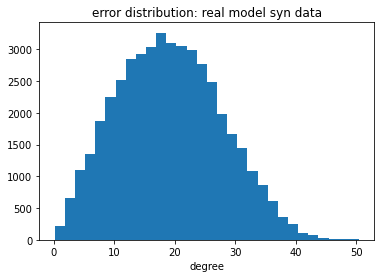

In [22]:
plt.hist(errors,bins=30)
plt.title("error distribution: real model syn data")
plt.xlabel("degree")

In [17]:
mean_error = errors.mean()
print(mean_error)

19.11353644744892


In [18]:
ix = 0
for k, v in images_errors.items():
    if ix >20:
        break
    print(k, v)
    ix += 1

face/fold05/1456.jpeg 50.47904511902257
face/fold05/1167.jpeg 49.232028219063686
face/fold05/2055.jpeg 49.16241681118959
face/fold05/1759.jpeg 49.13026135383074
face/fold05/1339.jpeg 48.93179121271838
face/fold05/1318.jpeg 48.74398066142051
face/fold05/2249.jpeg 48.48790168814665
face/fold05/1876.jpeg 48.41173094493133
face/fold05/1173.jpeg 47.84623576770494
face/fold04/346.jpeg 47.74601843581463
face/fold10/1361.jpeg 47.10054757813913
face/fold04/287.jpeg 46.493439595158506
face/fold11/2014.jpeg 45.86559052601537
face/fold05/2711.jpeg 45.728855646568924
face/fold05/2640.jpeg 45.71640856647229
face/fold05/1213.jpeg 45.58828075260133
face/fold08/1161.jpeg 45.58446883521423
face/fold12/2530.jpeg 45.51753971911874
face/fold05/1889.jpeg 45.47631204303258
face/fold09/2127.jpeg 45.34410776605838
face/fold06/977.jpeg 45.251976169878915
